### Setup for data loading

In [1]:
import cv2
import h5py
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F  # useful stateless functions

from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow
from matplotlib import pyplot as plt

import numpy as np
import random

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

using device: cuda


In [3]:
def check_accuracy(X, y, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        N = X.shape[0]
        for i in range(N):
            xi = X[i].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yi = y[i].unsqueeze(0).to(device=device, dtype=torch.long)
            scores = model(xi)
            _, preds = scores.max(1)
            num_correct += (preds == yi).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train_model(X, y, model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    N = X.shape[0]
    t = 0
    train_acc = []
    val_acc = []
    for e in range(epochs):
        for i in range(int(N/epochs)):
            Xt = X[t].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yt = y[t].unsqueeze(0).to(device=device, dtype=torch.long)
            
            scores = model(Xt)
            loss = F.cross_entropy(scores, yt)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
        
            t += 1
            if t % 1000 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                train_acc.append(100.*check_accuracy(X_train, y_train, model))
                val_acc.append(100.*check_accuracy(X_val,y_val, model))
                print()
    check_accuracy(X_train, y_train, model)
    check_accuracy(X_val, y_val, model)
                
#     plt.plot(list(range(1,int(t/1000)+1)), train_acc, label='train')
#     plt.plot(list(range(1,int(t/1000)+1)), val_acc, label='val')
#     plt.title('Classification accuracy history')
#     plt.xlabel('Iteration')
#     plt.ylabel('Clasification accuracy')
#     plt.legend()
#     plt.show()

### Loading human detection training data

In [4]:
# Load human detection training data.
# Each human sample is stored as lists of
# bbox[iClip][iFrame] = narray(N,D)
# where N = number of people in the frame, and 
# D = 4 (x, y, width, height)
hf = h5py.File('truth_data/ground_truth_data_train.mat', 'r')
data = hf.get('ground_truth_data')['list']
bbox = {}
for d in data[0]:
    imgname = ''.join([chr(x) for x in hf[d]['imgname'][:]])
    iClip = imgname[4:7]
    iFrame = int(imgname[8:12])
    if iClip not in bbox:
        bbox[iClip] = {}
    bbox[iClip][iFrame] = np.int_(hf[d]['bbox'][:].T/6)

In [5]:
# Check number of human dectection samples.
nData = 0
nFrame = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        nData += bbox[iClip][iFrame].shape[0]
        nFrame += 1
nData, nFrame

(1607, 420)

### Video data loading

In [6]:
# Save clips 
frame_every = 10
path = 'videos/'
frames = {}
for iClip in tqdm(bbox):
    videofile = path+'mv2_'+iClip+'.avi'
    cap = cv2.VideoCapture(videofile)
    frames[iClip] = {}
    frame_buffer = []
    iFrame = 1
    maxInClip = max(bbox[iClip])
    while iFrame <= maxInClip:
        cap.set(1, iFrame)
        ret, frame = cap.read()
        if ret:
            frame_buffer.append(frame)
        iFrame += frame_every
    frames[iClip][iFrame] = torch.from_numpy(np.stack(frame_buffer))

 20%|██        | 2/10 [02:36<10:24, 78.05s/it]

KeyboardInterrupt: 

### Training RNN with full image
We try to apply RNN on the full image of each frame.

In [29]:
# Generating data.
# True data
X_sample = torch.zeros(nData,3,35,17)
y_sample = torch.zeros(nData, )
i = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        for d in bbox[iClip][iFrame]:
            try:
                x, y, w, h = d
                x -= int((w-18)/2)
                y -= int((h-36)/2)
                for k in range(4,5):
                    data = frames[iClip][iFrame][k][y:y+35, x:x+17, :].to(dtype=torch.float32)
                    X_sample[i,:,:,:] = torch.unsqueeze(data.permute(2,0,1),0)
                y_sample[i] = 1
                i += 1
            except:
                continue
X_sample = X_sample[:i,]
y_sample = y_sample[:i,]

In [30]:
# False data are randomly sampled from images.
n = X_sample.shape[0]
for i in range(n):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    x = int(random.random()*705)
    y = int(random.random()*450)
    try:
        k = random.randint(0,4)
        data = frames[iClip][iFrame][k][y:y+35, x:x+17,:].to(dtype=torch.float32)
        X_sample = torch.cat((X_sample,torch.unsqueeze(data.permute(2,0,1),0)),0)
        y_sample = torch.cat((y_sample, torch.zeros(1)))
    except:
        continue

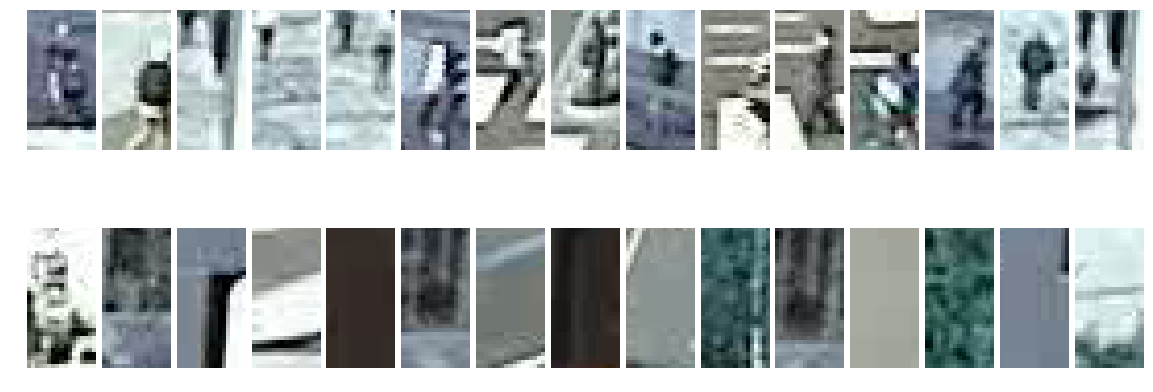

In [31]:
fig = plt.figure(figsize=(20,8))
for i in range(15):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    n = int(random.random()*1300)
    ax.imshow(X_sample[n].permute(1,2,0).to(dtype=torch.uint8))

for i in range(15):
    ax = fig.add_subplot(2,15,i+16)
    ax.axis('off')
    n = int(random.random()*800)+1600
    ax.imshow(X_sample[n].permute(1,2,0).to(dtype=torch.uint8))

fig.subplots_adjust(wspace=0.1, hspace=0)

In [32]:
N = X_sample.shape[0]
N_train = int(N*.8)
mask = list(range(N))
random.shuffle(mask)
X_train = X_sample[mask[:N_train],]
X_val = X_sample[mask[N_train:],]
y_train = y_sample[mask[:N_train],]
y_val = y_sample[mask[N_train:],]

In [33]:
# Train CNN
model = nn.Sequential(
    nn.Conv2d(3, 32, 5, padding=2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    # 16*W*H -> 50*W*H -> 2*W*H
    Flatten(),
    nn.Linear(16*17*35, 50),
    nn.ReLU(),
    nn.Linear(50, 2),
)
optimizer = optim.Adam(model.parameters(), lr=5.e-5, betas=(0.8, 0.999))
train_model(X_train, y_train, model, optimizer, epochs=10)

Iteration 1000, loss = 0.0354
Got 2009 / 2505 correct (80.20)
Got 490 / 627 correct (78.15)

Iteration 2000, loss = 0.2517
Got 2260 / 2505 correct (90.22)
Got 564 / 627 correct (89.95)

Got 2306 / 2505 correct (92.06)
Got 585 / 627 correct (93.30)


In [34]:
inputs = torch.from_numpy(np.array(frames['001'][201][4].permute(2, 0, 1).unsqueeze(0))).to(dtype=torch.float32)
filters = []
for param in model.parameters():
    filters.append(torch.from_numpy(param.cpu().detach().numpy()).to(dtype=torch.float32))
z = F.conv2d(inputs, filters[0], bias=filters[1], padding=2, stride=1)
z = F.instance_norm(z, weight=filters[2], bias=filters[3])
z = F.relu(z)
z = F.conv2d(z, filters[4], bias=filters[5], padding=1, stride=1)
z = F.instance_norm(z, weight=filters[6], bias=filters[7])
z = F.relu(z)
z = F.conv2d(z, filters[8], bias=filters[9], padding=1, stride=1)
z = F.instance_norm(z, weight=filters[10], bias=filters[11])
z = F.relu(z)
tmp = torch.reshape(filters[12],(50,16,17,35))
z = F.conv2d(z, tmp, bias=filters[13], padding=(8, 17), stride=1)
z = F.relu(z)
z = torch.mm(filters[14],z[0].view(50, -1)).view(2,480,720)+filters[15].view(2,1,1)

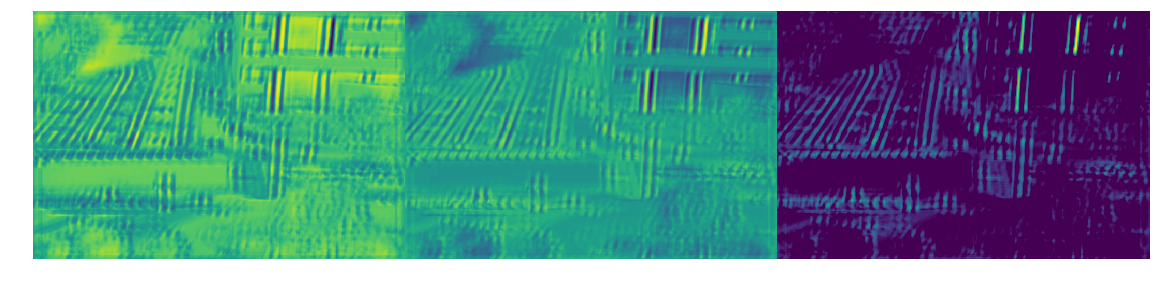

In [35]:
fig = plt.figure(figsize=(20,6))
for i in range(2):
    ax = fig.add_subplot(1,3,i+1)
    ax.axis('off')
    ax.imshow(z[i, :, :].numpy())
ax = fig.add_subplot(1,3,3)
ax.axis('off')
ax.imshow((z[1, :, :] - z[0, :, :]).numpy(), vmin=0, vmax=10)
fig.subplots_adjust(wspace=0, hspace=0)

### Training data with (3d; stack of) images
First, we will try training the data with still images of a person. Since the images of a person in the training data are not equal, we try 1) crop/zero-padding the image to equal size, or 2) scale the image.

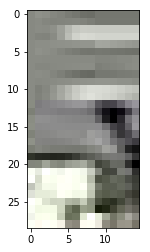

In [37]:
# Generating train data. All images are cropped to (36, 18).# Genera 
# True data
X_sample = torch.zeros(nData,3,frame_buffer_n,29,15)
y_sample = torch.zeros(nData, )
i = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        for d in bbox[iClip][iFrame]:
            try:
                x, y, w, h = d
                x -= int((w-15)/2)
                y -= int((h-29)/2)
                if i == 100:
                    imshow(frames[iClip][iFrame][-1, y:y+29, x:x+15,:])
                data = frames[iClip][iFrame][:, y:y+29, x:x+15, :].to(dtype=torch.float32)
                X_sample[i,:,:,:,:] = torch.unsqueeze(data.permute(3,0,1,2), 0)
                y_sample[i] = 1
                i += 1
            except:
                continue
X_sample = X_sample[:i,]
y_sample = y_sample[:i,]

100%|██████████| 1569/1569 [00:21<00:00, 71.64it/s]


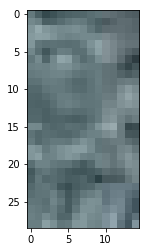

In [38]:
# False data are randomly sampled from images.# False  
n = X_sample.shape[0]
for i in tqdm(range(1 * n)):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    x = int(random.random()*705)
    y = int(random.random()*450)
    try:
        if i == 100:
            imshow(frames[iClip][iFrame][-1, y:y+29, x:x+15,:])
        data = frames[iClip][iFrame][:, y:y+29, x:x+15,:].to(dtype=torch.float32)
        X_sample = torch.cat((X_sample,torch.unsqueeze(data.permute(3,0,1,2),0)),0)
        y_sample = torch.cat((y_sample, torch.zeros(1)))
    except:
        continue

In [39]:
N = X_sample.shape[0]
N_train = int(N*.8)
mask = list(range(N))
random.shuffle(mask)
X_train = X_sample[mask[:N_train],]
X_val = X_sample[mask[N_train:],]
y_train = y_sample[mask[:N_train],]
y_val = y_sample[mask[N_train:],]

In [40]:
# Train CNN
model = nn.Sequential(
    nn.Conv3d(3, 32, 5, padding=2),
    nn.BatchNorm3d(32),
    nn.ReLU(),
    nn.Conv3d(32, 32, 3, padding=1),
    nn.BatchNorm3d(32),
    nn.ReLU(),
    nn.Conv3d(32, 16, 3, padding=1),
    nn.BatchNorm3d(16),
    nn.ReLU(),
    nn.Conv3d(16, 8, 3, padding=1),
    nn.BatchNorm3d(8),
    nn.ReLU(),
    Flatten(),
    nn.Linear(5*8*15*29, 20),
    nn.ReLU(),
    nn.Linear(20, 2),
)
optimizer = optim.Adam(model.parameters(), lr=5.e-5, betas=(0.9, 0.999))
train_model(X_train, y_train, model, optimizer, epochs=10)

Iteration 1000, loss = 0.2038
Got 1565 / 2510 correct (62.35)
Got 375 / 628 correct (59.71)

Iteration 2000, loss = 0.6018
Got 2270 / 2510 correct (90.44)
Got 561 / 628 correct (89.33)

Got 2353 / 2510 correct (93.75)
Got 580 / 628 correct (92.36)


In [70]:
inputs = torch.from_numpy(np.array(frames['002'][201].permute(3, 0, 1, 2).unsqueeze(0))).to(dtype=torch.float32)
filters = []
for param in model.parameters():
    filters.append(torch.from_numpy(param.cpu().detach().numpy()).to(dtype=torch.float32))
z = F.conv3d(inputs, filters[0], bias=filters[1], padding=2)
z = F.instance_norm(z, weight=filters[2], bias=filters[3])
z = F.relu(z)
z = F.conv3d(z, filters[4], bias=filters[5], padding=1, stride=1)
z = F.instance_norm(z, weight=filters[6], bias=filters[7])
z = F.relu(z)
z = F.conv3d(z, filters[8], bias=filters[9], padding=1, stride=1)
z = F.instance_norm(z, weight=filters[10], bias=filters[11])
z = F.relu(z)
z = F.conv3d(z, filters[12], bias=filters[13], padding=1, stride=1)
z = F.instance_norm(z, weight=filters[14], bias=filters[15])
z = F.relu(z)
tmp = torch.reshape(filters[16],(20,8,5,15,29))
z = F.conv3d(z, tmp, bias=filters[17], padding=(0, 7, 14), stride=1)
z = F.relu(z)
z = torch.mm(filters[18],z.view(20, -1)).view(2,480,720)+filters[19].view(2,1,1)

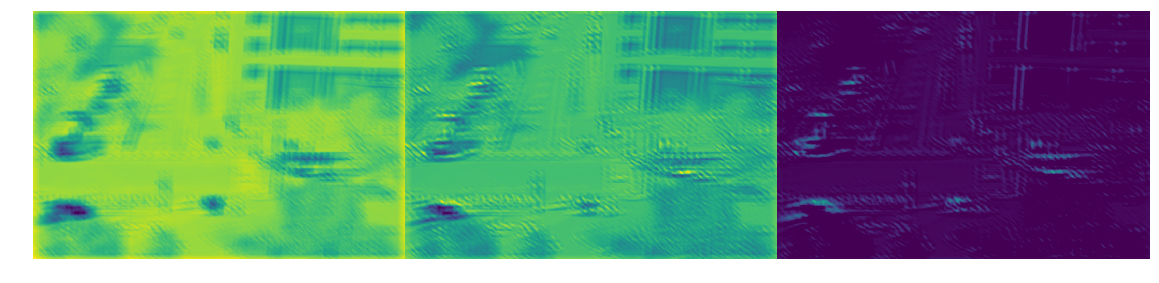

In [71]:
fig = plt.figure(figsize=(20,6))
for i in range(2):
    ax = fig.add_subplot(1,3,i+1)
    ax.axis('off')
    ax.imshow(z[i, :, :].numpy())
ax = fig.add_subplot(1,3,3)
ax.axis('off')
ax.imshow((z[1, :, :] - z[0, :, :]).numpy(), vmin=0, vmax=10)
fig.subplots_adjust(wspace=0, hspace=0)

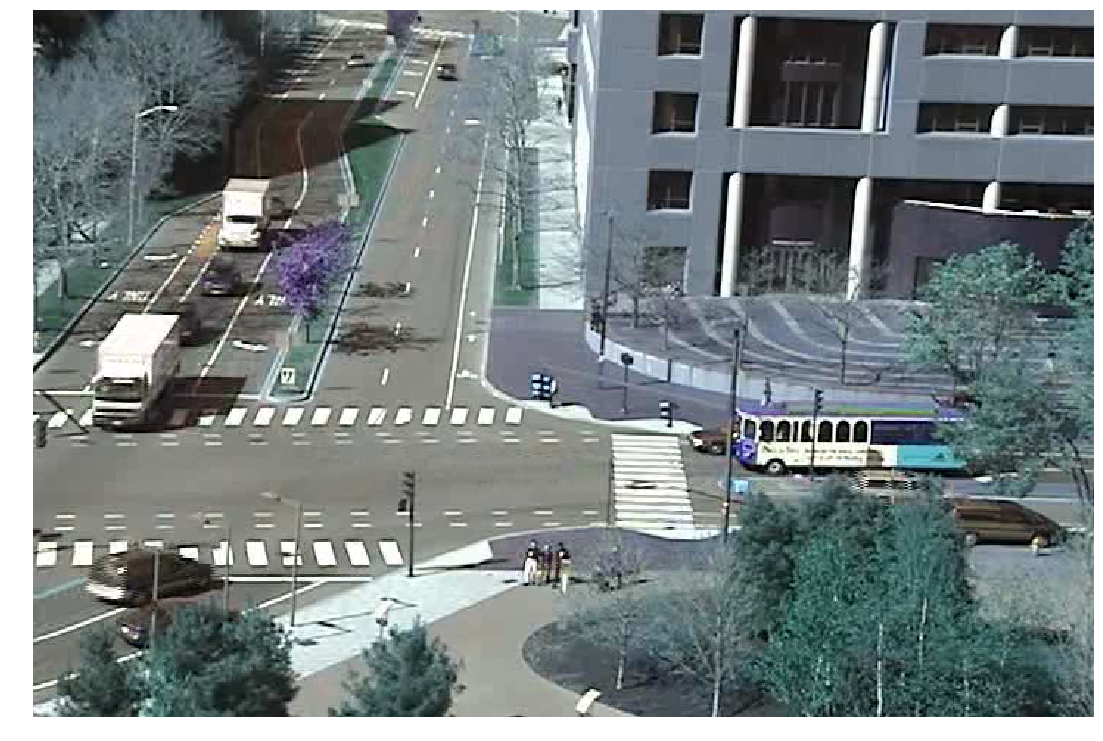

In [76]:
fig = plt.figure(figsize=(20,13))
ax = fig.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(frames['002'][201][4].to(dtype=torch.uint8))